## CLUSTERING & DATA WRANGLING LESSON

25 January 2023


In [15]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from env import sql_connexion



In [2]:
# getting sql_connexion from acquire.py

url = sql_connexion('mall_customers')

In [3]:
# defining the query

query = '''
        SELECT * 
        FROM customers
        '''

In [6]:
# putting it together 

df = pd.read_sql(query, url)
df.head(3)

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


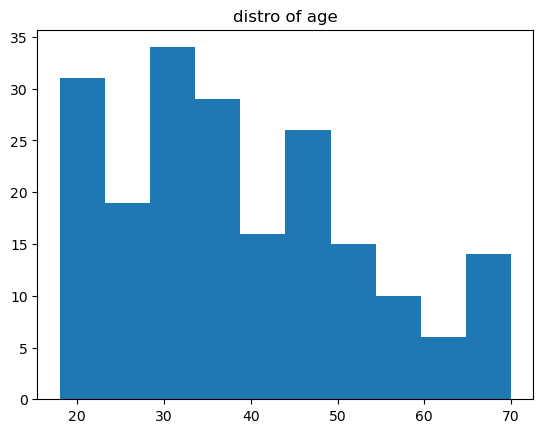

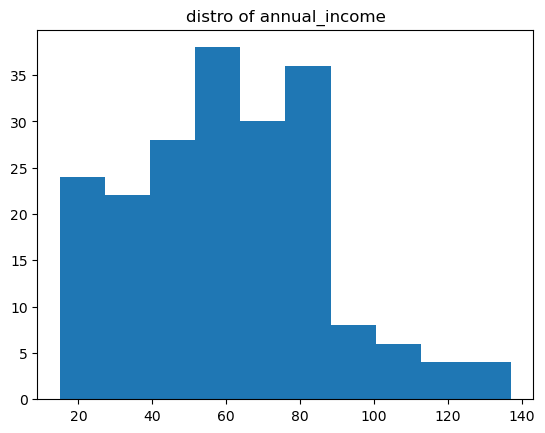

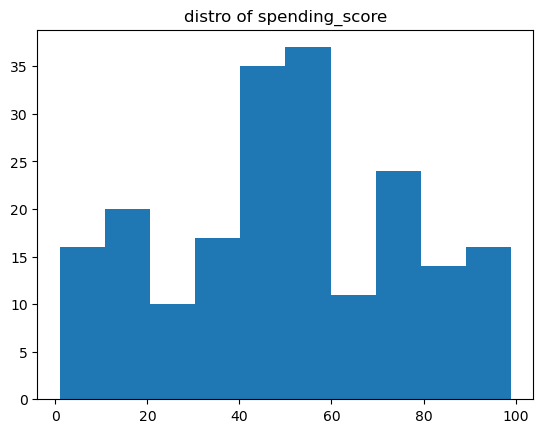

In [16]:
# plotting the numeric columns

num_cols = ['age', 'annual_income', 'spending_score']

for col in num_cols:
    
    plt.hist(df[col])
    plt.title(f'distro of {col}')
    plt.show()

In [17]:
# checking for nulls

df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

## DETECT OUTLIERS USING IQR

THE NUMBER OF OBSERVATIONS THAT FALL INTO EACH BIN (25pc, 50pc, 75pc, 100pc).  

IQR takes 25th percentile & 75th percentile on a feature in the dataset. I.e, the lowest 25pc of spending scores, the lowest 75th percentile of spending scores.  

    IQR = q3 - q1  

(Anything outside the upper or lower bound is an outlier.)
    
```upper_bound = q3 + k * IQR```
    
```lower_bound = q1 - k * IQR```  

    Acceptable list of values for k : 1.5, 2, 3.  
    Keep k consistent.
    
    
    
    

In [20]:
# looking at 25th & 75th quantiles

q1, q3 = df['spending_score'].quantile([0.25, 0.75])

q1, q3 

# 25pc have a spending score of 34.75 or less
# 75pc have a spending score of 73.00 or less (25pc have a spending_score exceeding 73.00.)

(34.75, 73.0)

In [22]:
#spending_score IQR 

ss_iqr = q3 - q1
ss_iqr

38.25

In [23]:
# finding upper and lower bounds

k = 1.5

ss_upper = q3 + k * ss_iqr

ss_lower = q1 - k * ss_iqr

ss_upper, ss_lower

# what to make of a negative score ? It's acceptable to have no lower outliers
# we've defined the bounds to find outliers

(130.375, -22.625)

In [24]:
#what is the min ss ?

df['spending_score'].min()

1

In [27]:
# determing whether any ss is above the upper bound

np.where(df['spending_score'] > ss_upper, 1, 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [29]:
# function to examine the other numerical columns 

# by default, unless otherwise specified, in this function that we're creating, k will equal 1.5

def upper_outlier_detector(dataframe, column, k = 1.5):
    
    #finding the quantiles for a particular column
    q1, q3 = dataframe[column].quantile([0.25, 0.75])
    
    # make iqr
    iqr = q3 - q1
    
    # set upper outlier boundary
    upper_bound = q3 + k * ss_iqr
    
    # set lower outlier boundary
    lower_bound = q1 - k * ss_iqr
    
    # determing whether anything is above the upper bound
    return np.where(dataframe[column] > upper_bound, 1, 0)

In [34]:
# assigning new columns to dataframe based on above function

my_list = ['age', 'annual_income']

for col in my_list:
    
    df[f'{col}_upper_outliers'] = upper_outlier_detector(df, col)
    
df.head(1)

,customer_id,gender,age,annual_income,spending_score,age_upper_outliers,annual_income_upper_outliers
0,1,Male,19,15,39,0,0


In [36]:
# finding outliers

df[['age_upper_outliers', 'annual_income_upper_outliers']].sum()

age_upper_outliers              0
annual_income_upper_outliers    2
dtype: int64

In [40]:
# looking at the 2 outliers

df[df['annual_income_upper_outliers'] == 1]

,customer_id,gender,age,annual_income,spending_score,age_upper_outliers,annual_income_upper_outliers
198,199,Male,32,137,18,0,1
199,200,Male,30,137,83,0,1


In [41]:
# finding mean of annual_income

df['annual_income'].mean()

# we can see that these two entries have higher than the mean annual incomes.

60.56